In [117]:
# Importing all the required libraries

import numpy as np 
import pandas as pd 
import os
import cv2
import csv
from time import time
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt
%matplotlib inline


**Data Upload**

Since I Have used the Google Colab to train the model using Transfer learning approach. I have uploaded the dataset and labelled CSV file in my google drive and connected my google drive with Colab.

In [118]:
# Mounting  google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
# unzipping the dataset file
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/archive (2).zip', 'r') as zip_ref:
    zip_ref.extractall()

**Data Processing**

Since the dataset contains many fields irrelevent to health of Bees, therefore processing the data using Pandas Dataframe and creating a labelled training labelled data of Bees Health. 

In [120]:

df = pd.read_csv('/content/bee_data.csv')
img_names = list(df['file'])

In [121]:
df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [122]:
# reading the images from the folder

from skimage.io import imread
import matplotlib.pyplot as plt
img_paths = []

for img in img_names:
    img_paths.append('/content/bee_imgs/bee_imgs/'+img)

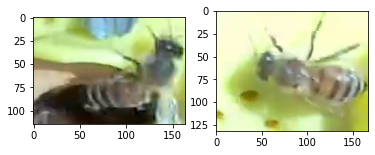

In [160]:
# visualization of images from the dataset 

img0 = imread(img_paths[0])
img2 = imread(img_paths[2])

plt.subplot(121)
plt.imshow(img0)
plt.subplot(122)
plt.imshow(img2)


In [124]:
# Resizing the images to the fixed size of 100*100*3

from skimage.transform import rescale, resize, downscale_local_mean
img_list = []
for img in img_paths:
    img_list.append(resize(imread(img),(100,100,3)))

In [125]:
img_np = np.array(img_list)
health = df['health']


In [126]:
# Fetching all the unique values from the Health column

df['health'].unique()

array(['hive being robbed', 'healthy', 'few varrao, hive beetles',
       'ant problems', 'missing queen', 'Varroa, Small Hive Beetles'],
      dtype=object)

In [127]:
c=0
for i in df['health'].unique():
    health[health==i] = c
    c=c+1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [129]:
# converting the labels to one hot vector

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
health_en = enc.fit_transform(np.array(health).reshape(-1,1))

In [132]:
p = np.random.permutation(len(health))
img_np = img_np[p]
health_en = health_en[p]

In [133]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_np, health_en, test_size=0.15, random_state=100)

In [134]:
y_train = y_train.todense()

In [139]:
y_test = y_test.todense()

**Image Augmentation**

Image augmentation is done to avoid overfitting of the model, ImageDataGenerator class from Keras is useed to perform the augmentation. zoom,flip and shift techniques are used to perform augmenation.

In [136]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=180,  
            zoom_range = 0.1,  
            width_shift_range=0.2,  
            height_shift_range=0.2, 
            horizontal_flip=True, 
            vertical_flip=True,
            validation_split=0.1)
datagen.fit(X_train)

**Training of Model**

I have used the Transfer learning==> Feature extraction approach to train the model. I have used the VGG-19 model in Keras pretrained with 'Imagenet weights'. Since I have used Feature extraction approach to train the model, I have made changes only in last classification layer of model. Since the dataset contains 6 Health classes. I have added the ouput layer which will output this 6 classes. I have used optimizer as Adam, categorical cross entropy loss and learning rate of 0.0001 with batch size of 256. I have trained the model for 50 epochs.



In [137]:
classes = 6
batch = 256
epochs = 50
learning_rate = 0.0001

def results(model):
  adam = Adam(lr=learning_rate)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  start = time()
  history = model.fit(datagen.flow(X_train,y_train),validation_data=(X_test,y_test),batch_size=batch, epochs=epochs, verbose=1)
  train_time = time() - start

  model.summary()

  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  start = time()
  test_loss, test_acc = model.evaluate(X_test, y_test)
  test_time = time() - start
  print('\nTrain time: ', train_time)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)
  print('Test time: ', test_time)

Epoch 1/50
138/138 [==============================] - 19s 132ms/step - loss: 0.8244 - accuracy: 0.6995 - val_loss: 1.0087 - val_accuracy: 0.6186
Epoch 2/50
138/138 [==============================] - 18s 129ms/step - loss: 0.3485 - accuracy: 0.8707 - val_loss: 0.3300 - val_accuracy: 0.8737
Epoch 3/50
138/138 [==============================] - 18s 129ms/step - loss: 0.2695 - accuracy: 0.9001 - val_loss: 1.0240 - val_accuracy: 0.5941
Epoch 4/50
138/138 [==============================] - 18s 130ms/step - loss: 0.2098 - accuracy: 0.9247 - val_loss: 0.2702 - val_accuracy: 0.9124
Epoch 5/50
138/138 [==============================] - 18s 130ms/step - loss: 0.2065 - accuracy: 0.9191 - val_loss: 0.2265 - val_accuracy: 0.9137
Epoch 6/50
138/138 [==============================] - 18s 131ms/step - loss: 0.2125 - accuracy: 0.9222 - val_loss: 0.5340 - val_accuracy: 0.8028
Epoch 7/50
138/138 [==============================] - 18s 131ms/step - loss: 0.1655 - accuracy: 0.9341 - val_loss: 0.1525 - val_ac

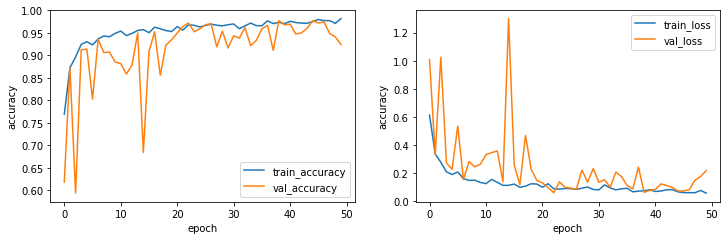

25/25 [==============================] - 1s 38ms/step - loss: 0.2167 - accuracy: 0.9240

Train time:  911.9537265300751
Test accuracy: 0.9239690899848938
Test loss: 0.2166842818260193
Test time:  1.0353612899780273


In [140]:
model = Sequential()
model.add(VGG19(weights='imagenet', include_top=False, input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(6, activation='softmax'))

results(model)

In [141]:
classes = { 0:'hive being robbed',
            1:'healthy', 
            2:'few varrao, hive beetles', 
            3:'ant problems', 
            4:'missing queen', 
            5:'Varroa, Small Hive Beetles'}

classes_6 = classes.values()
classes_6_list = list(classes_6)
#array(['hive being robbed', 'healthy', 'few varrao, hive beetles',
 #      'ant problems', 'missing queen', 'Varroa, Small Hive Beetles'],
  #    dtype=object)

**Evaluation of model**

For evaluation , I have evaluated the model using precision, recall and F1-score metrics. I have also used confusion matrix to evaluate the model.

In [142]:
#predicted labels by the model
y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred,axis = 1)

y_true = np.argmax(y_test,axis = 1)


In [143]:
#confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true,y_pred_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [144]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

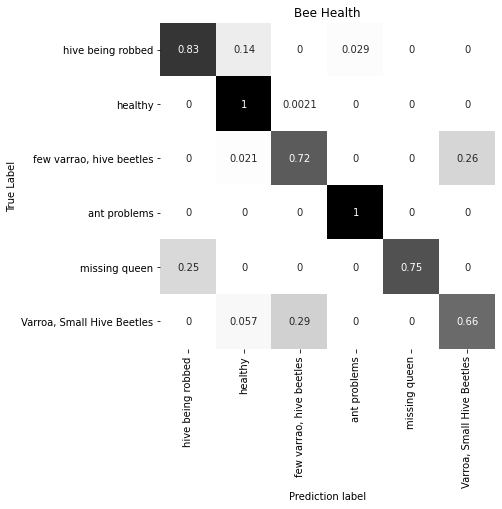

In [147]:
#plotting confusion matrix
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix

cm_df = pd.DataFrame(cm, index = classes_6_list,
                     columns = classes_6_list
                    )


plt.figure(figsize = (6,6))
sns.heatmap(cm_df, annot = True,cmap='Greys',cbar=False)
plt.title('Bee Health')
plt.ylabel('True Label')
plt.xlabel('Prediction label')
plt.show()



In [148]:
from sklearn.metrics import classification_report

In [149]:
#precision,recall and f1 score 

report = classification_report(y_true,y_pred_labels,target_names=classes_6_list)
print(report)

                            precision    recall  f1-score   support

         hive being robbed       0.97      0.83      0.89        35
                   healthy       0.98      1.00      0.99       485
  few varrao, hive beetles       0.76      0.72      0.74        95
              ant problems       0.99      1.00      0.99        87
             missing queen       1.00      0.75      0.86         4
Varroa, Small Hive Beetles       0.65      0.66      0.65        70

                  accuracy                           0.92       776
                 macro avg       0.89      0.82      0.85       776
              weighted avg       0.92      0.92      0.92       776



In [ ]:
import matplotlib.pyplot as plt

**Results from the model**

Here are some of the images from the testing data where model has predicted the label correctly for the image.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Prediction: healthy
Score: 0.9999777


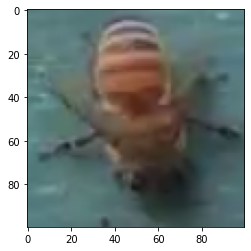

In [154]:
#plotting label for predicted images and confidencee score predicted by the model

a= y_pred[6]
ind=np.argmax(a)
max = np.amax(a) 
pred = model.predict_classes(X_test)[6]
label = classes[pred]
imgplot = plt.imshow(X_test[6])
print('Prediction:',label)
print('Score:',max)



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Prediction: hive being robbed
Score: 0.99998474


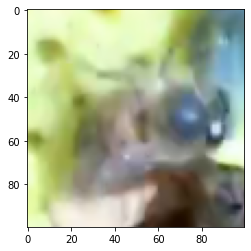

In [156]:
a= y_pred[218]
ind=np.argmax(a)
max = np.amax(a) 
pred = model.predict_classes(X_test)[121]
label = classes[pred]
imgplot = plt.imshow(X_test[121])
print('Prediction:',label)
print('Score:',max)
